# Stiffness Analysis

I want to make a comprehensive analysis of stiffness and comparison of all the methods I've implemented. I should also include the Adams-Moulden or whatever.

Some potentially useful resources:

- Section 4.6 of the book
- https://en.wikipedia.org/wiki/Stiff_equation
- https://www.mathworks.com/company/technical-articles/stiff-differential-equations.html
- https://web.archive.org/web/20230926233120/http://acmbulletin.fiit.stuba.sk/vol4num3/satek.pdf
- https://math.stackexchange.com/questions/4217585/stiff-odes-trouble-detecting-stiffness-from-the-plot-of-an-ode?noredirect=1&lq=1

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## Implementation of main algorithms

### Euler

In [52]:
def euler_method(F, t0, x0, h, n_steps):
    dim = len(x0)
    t_end = t0 + h*n_steps
    t = np.arange(t0, t_end, h)
    x = np.zeros((n_steps, dim))
    x[0] = x0

    for n in range(1, n_steps):
        x[n] = x[n-1] + h * F(t[n-1], x[n-1])

    return t, x

### Runge-Kutta

In [2]:
def RK_method(F, t0, x0, h, n_steps, a, b, c):
    dim = len(x0)
    l = len(b)
    t = np.arange(t0, t0 + h*n_steps, h)
    x = np.zeros((n_steps, dim))
    x[0] = x0
    k = np.zeros((l, dim))

    for n in range(1, n_steps):
        k[0] = F(t[n-1], x[n-1])
        for i in range(1, l):
            t_i = t[n-1] + h * c[i]
            x_i = x[n-1] + h * np.dot(a[i-1][:i], k[:i])
            k[i] = F(t_i, x_i)
        x[n] = x[n-1] + h * np.dot(b, k)

    return t, x

In [3]:
# 3-stage Runge-Kutta
def RK3(F, t0, x0, h, n_steps):
    a = np.array(
        [[0.5, 0], [-1, 2]]
    )
    b = np.array([1/6, 4/6, 1/6])
    c = np.array([0, 0.5, 1])
    return RK_method(F, t0, x0, h, n_steps, a, b, c)

# Classical (4-stage) Runge-Kutta
def RK4(F, t_span, x0, n_steps):
    a = np.array(
        [[0.5, 0, 0],
         [0, 0.5, 0],
         [0, 0, 1]]
    )
    b = np.array([1/6, 2/6, 2/6, 1/6])
    c = np.array([0, 0.5, 0.5, 1])
    return RK_method(F, t_span, x0, n_steps, a, b, c)

### RKF45

In [25]:
# Lists with Butcher tableau for RKF45
a = np.array([
    [1/4, 0, 0, 0, 0],
    [3/32, 9/32, 0, 0, 0],
    [1932/2197, -7200/2197, 7296/2197, 0, 0],
    [439/216, -8, 3680/513, -845/4104, 0],
    [-8/27, 2, -3544/2565, 1859/4104, -11/40]
])
b4 = np.array([25/216, 0, 1408/2565, 2197/4104, -1/5, 0])
b5 = np.array([16/135, 0, 6656/12825, 28561/56430, -9/50, 2/55])
c = np.array([0, 1/4, 3/8, 12/13, 1, 1/2])

# Should this even be here?
MAX_ERROR = 1e-6
MIN_STEP = 1e-4
MAX_STEP = 5e-1

# Dynamically compute the stepsize (h)
def RKF45_step(F, t, x, h):
    dim = len(x)
    l = len(c)
    k = np.zeros((l, dim))

    k[0] = F(t, x)
    for i in range(1, l):
        k[i] = F(t + c[i] * h, x + np.dot(a[i-1, :i], k[:i]))
    # Compute next time
    t_next = t + h

    # Compute next x with order 4 and 5 methods
    x4 = x + h * np.dot(b4, k)
    x5 = x + h * np.dot(b5, k)

    # Compute error
    error = np.linalg.norm(x4 - x5)

    # Update h
    h_next = h * np.power(MAX_ERROR / (2 * error), 1/4)
    
    # Return computation, possibly clipping h_next, or repeat with finer approximation
    if error <= MAX_ERROR/2:
        return t_next, x4, h_next
    elif h_next < MIN_STEP or h_next > MAX_STEP:
        return t_next, x4, np.clip(h_next, MIN_STEP, MAX_STEP)
    else:
        return RKF45_step(F, x, t, h_next)
    
# The main function
def RKF45(F, t0, x0, h0, n_steps):
    # Initialize stuff
    dim = len(x0)
    t = np.zeros((n_steps))
    x = np.zeros((n_steps, dim))
    h = np.zeros((n_steps))
    t[0], x[0], h[0] = t0, x0, h0

    for n in range(1, n_steps):
        t[n], x[n], h[n] = RKF45_step(F, x[n-1], t[n-1], h[n-1])
        
    return t, x, h

### Adams-Bashforth

In [4]:
def compute_a_adams(k):
    # return ndarray of a[i]'s
    # which are the integral of pochhammer over i!, 0 <= i < k
    # the book gives a recursive formula to compute a[i]
    a = np.ones((k))
    for i in range(1, k):
        for j in range(i):
            a[i] -= a[j] / (i+1-j)
    return a

def compute_delF(k, F, t, x):
    # t = [t_n-k, ..., t_n-1]
    # x = [x_n-k, ..., x_n-1]
    dim = len(x[0])
    delF = np.zeros((k, k, dim))
    for j in range(k):
        delF[0, j, :] = F(t[j], x[j])
    for i in range(1, k):
        for j in range(i, k):
            delF[i, j] = delF[i-1, j] - delF[i-1, j-1]
    return delF[:, k-1]

def adams_bashforth(F, t_span, x0, n_steps, k):
    dim = len(x0)
    t_start, t_end = t_span
    h = (t_end - t_start) / (n_steps - 1)

    t = np.linspace(t_start, t_end, n_steps)
    x = np.zeros((n_steps, dim))
    a = compute_a_adams(k)

    # Compute first k steps with RK
    A = np.array(
    [[0.5, 0], [-1, 2]]
    )
    B = np.array([1/6, 4/6, 1/6])
    C = np.array([0, 0.5, 1])
    _, x_first_k = RK_method(F, (t_start, t_start + h*(k-1)), x0, k, A, B, C)
    x[:k] = x_first_k

    for n in range(k, n_steps):
        delF = compute_delF(k, F, t[n-k:n], x[n-k:n])
        x[n] = x[n-1] + h * np.dot(a, delF)
    
    return t, x

### Implicit methods

In [ ]:
def newtons_method(x1, f, df, n):
    # Initial guess
    x = x1
    for i in range(n):
        if f(x) != 0 and df(x) != 0:
            x -= f(x) / df(x)
        else:
            return x
    return x

def implicit_euler(F, dF_dx, t_span, x0, n_steps, k):
    t_start, t_end = t_span
    h = (t_end - t_start) / (n_steps - 1)

    t = np.linspace(t_start, t_end, n_steps)
    x = np.zeros(n_steps)
    x[0] = x0
    
    for n in range(1, n_steps):
        f = lambda y: x[n-1] + h * F(t[n], y) - y
        df = lambda y: h * dF_dx(t[n], y) - 1
        x[n] = newtons_method(x[n-1], f, df, k)
    
    return t, x

## Many stiff ODEs

Add lots of stiff ODEs and compare all the methods with them.

In [63]:
decay_rate = 15

def exp_decay(t, x):
	Dx = -decay_rate * x[0]
	return np.array([Dx])

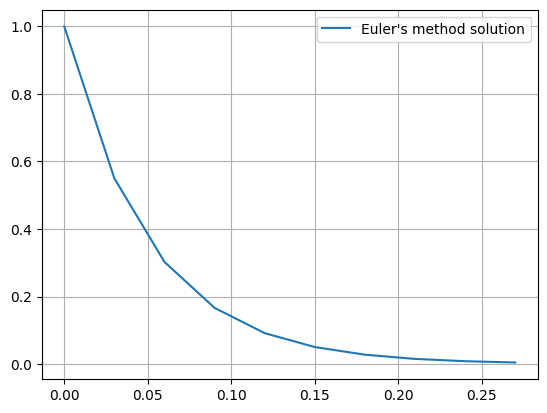

In [67]:
t0 = 0
x0 = [1]
h =0.03
n_steps = 10

# Solve ODE with Euler's method
t_euler, x_euler = euler_method(exp_decay, t0, x0, h, n_steps)

# Plot solutions
plt.plot(t_euler, x_euler[:, 0], label="Euler's method solution")
plt.legend()
plt.grid(True)
plt.show()